# Modélisation

## 1. Modèle simple
dummy model se traduit par "modèle bête"

### 1.1. Première étape : clean data

In [1]:
import pandas as pd

def clean_data(df : pd.DataFrame) :
    dataframe2 = df.copy()
   
    dataframe2["smoker"] = dataframe2["smoker"].apply( lambda x : 1 if x == "yes" else 0)
    dataframe2["high_bmi"] = dataframe2["bmi"].apply( lambda x : 1 if x >30 else 0)
    dataframe2["smoker_high_bmi"] = dataframe2["bmi"]*dataframe2["smoker"]
   
    #dataframe2["sex"] = dataframe2["sex"].apply( lambda x : 1 if x == "male" else 0)
    #dataframe2["is_north"] = dataframe2["region"].apply( lambda x : 1 if str(x).startswith("north") else 0)
    #dataframe2["is_west"] = dataframe2["region"].apply( lambda x : 1 if str(x).endswith("west") else 0)

    dataframe2 = dataframe2.drop("children", axis=1)
    dataframe2 = dataframe2.drop("sex", axis=1)
    dataframe2 = dataframe2.drop("region", axis=1)


    return dataframe2

df_initial = pd.read_csv("dataset.csv", sep=",", index_col=False)
df_modifie = clean_data(df_initial)
#df_modifie.to_csv("clean_dataset.csv", index=False)

### 1.2. Deuxième étape : split data

In [2]:
import sklearn.model_selection as sklms
import numpy as np

#df = pd.read_csv("clean_dataset.csv", sep=",", index_col=False)
df = df_modifie

#data_original = np.array(df, dtype=float)
y = df['charges']
X = df.drop('charges', axis=1)

# pour pouvoir comparer le score
X_train, X_test, y_train, y_test = sklms.train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42, stratify=X['smoker'])


### 1.3. Troisième étape : model choice


In [3]:
import sklearn.linear_model as skllm

model = skllm.Lasso(alpha=1)
model.fit(X_train, y_train)

#coefficients
for i in range(len(X_train.columns.array)):
    colname = X_train.columns.array[i]
    coeff = model.coef_[i]
    print(f"{colname} : {coeff}")

age : 270.5708949352384
bmi : -223.08361034180876
smoker : -21449.43275298731
high_bmi : 3256.4206946159306
smoker_high_bmi : 1477.0038917020702


### 1.4. Quatrième étape : vérification

In [4]:
score = model.score(X_test, y_test)
print(f"  score  = {score} ")

y_predicted = model.predict(X_test)

import sklearn.metrics as skl_metrics

rmse = skl_metrics.root_mean_squared_error(y_test, y_predicted)
Rsquare = skl_metrics.r2_score(y_test, y_predicted)

print(f"r2_score = {Rsquare} ")
print(f"sklearn.metrics.mean_squared_error = {rmse}]")

  score  = 0.8475717681695789 
r2_score = 0.8475717681695789 
sklearn.metrics.mean_squared_error = 4724.110535491985]


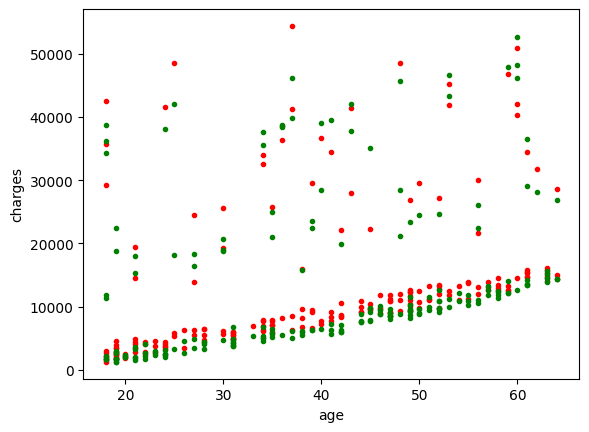

In [5]:
import matplotlib.pyplot as plt

#Charges = f ( age )
plt.xlabel("age")
plt.ylabel("charges")
plt.plot(X_test["age"], y_predicted, "r.")
plt.plot(X_test["age"], y_test, "g.")
plt.show()

## 2. Utilisation du pipeline de sk learn

In [6]:
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline, make_union
from sklearn.compose import make_column_transformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OrdinalEncoder, OneHotEncoder, Binarizer, PolynomialFeatures,MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV

import seaborn as sns

import pandas as pd 
import numpy as np 

dataframe = pd.read_csv("dataset.csv", sep=",", index_col=False)
dataframe.head() 

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [7]:
bins = [0, 18.5, 25, 30, 35, 40, float('inf')]
labels = ['insuffisant', 'normal', 'surpoids', 'obesite_g1', 'obesite_g2', 'obesite_g3']
dataframe['bmi_category'] = pd.cut(dataframe['bmi'], bins=bins, labels=labels, right=False)

In [8]:
y = dataframe['charges']
X = dataframe.drop('charges', axis=1)

# pour pouvoir comparer le score
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42, stratify=X['smoker'])


In [9]:
pipe1 = make_pipeline( 
    make_column_transformer(
        (StandardScaler(), ['age']),
        (OrdinalEncoder(categories=[['female', 'male']]), ['sex']),
        (OneHotEncoder(), ['bmi_category']),
        (OrdinalEncoder(categories=[['no', 'yes']]), ['smoker']),
        (StandardScaler(), ['children']), 
        (OneHotEncoder(), ['region']), 
        remainder='passthrough'))

pipe1.fit_transform(X_train, y_train)
columns = pipe1.get_feature_names_out()

columns


array(['standardscaler-1__age', 'ordinalencoder-1__sex',
       'onehotencoder-1__bmi_category_insuffisant',
       'onehotencoder-1__bmi_category_normal',
       'onehotencoder-1__bmi_category_obesite_g1',
       'onehotencoder-1__bmi_category_obesite_g2',
       'onehotencoder-1__bmi_category_obesite_g3',
       'onehotencoder-1__bmi_category_surpoids',
       'ordinalencoder-2__smoker', 'standardscaler-2__children',
       'onehotencoder-2__region_northeast',
       'onehotencoder-2__region_northwest',
       'onehotencoder-2__region_southeast',
       'onehotencoder-2__region_southwest', 'remainder__bmi'],
      dtype=object)

In [10]:

preprocessor = make_pipeline( 
    make_column_transformer(
        (StandardScaler(), ['age']),
        (OrdinalEncoder(categories=[['female', 'male']]), ['sex']),
        (StandardScaler(), ['bmi']),
        (OneHotEncoder(), ['bmi_category']),
        (OrdinalEncoder(categories=[['no', 'yes']]), ['smoker']),
        (StandardScaler(), ['children']), 
        (OneHotEncoder(), ['region']), 
        remainder='passthrough'), 
    PolynomialFeatures(degree=2))
    
preprocessor

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler-1',
                                                  StandardScaler(), ['age']),
                                                 ('ordinalencoder-1',
                                                  OrdinalEncoder(categories=[['female',
                                                                              'male']]),
                                                  ['sex']),
                                                 ('standardscaler-2',
                                                  StandardScaler(), ['bmi']),
                                                 ('onehotencoder-1',
                                                  OneHotEncoder(),
                                                  ['bmi_category']),
                                                 ('ordinalencoder-2',
                                                  OrdinalEncoder(categories=[['no',
                                                                              'yes']]),
                                                  ['smoker']),
                                                 ('standardscaler-3',
                                                  StandardScaler(),
                                                  ['children']),
                                                 ('onehotencoder-2',
                                                  OneHotEncoder(),
                                                  ['region'])])),
                ('polynomialfeatures', PolynomialFeatures())])

In [11]:
preprocessor.fit_transform(X_train, y_train)
columns = preprocessor.get_feature_names_out()

columns

array(['1', 'standardscaler-1__age', 'ordinalencoder-1__sex',
       'standardscaler-2__bmi',
       'onehotencoder-1__bmi_category_insuffisant',
       'onehotencoder-1__bmi_category_normal',
       'onehotencoder-1__bmi_category_obesite_g1',
       'onehotencoder-1__bmi_category_obesite_g2',
       'onehotencoder-1__bmi_category_obesite_g3',
       'onehotencoder-1__bmi_category_surpoids',
       'ordinalencoder-2__smoker', 'standardscaler-3__children',
       'onehotencoder-2__region_northeast',
       'onehotencoder-2__region_northwest',
       'onehotencoder-2__region_southeast',
       'onehotencoder-2__region_southwest', 'standardscaler-1__age^2',
       'standardscaler-1__age ordinalencoder-1__sex',
       'standardscaler-1__age standardscaler-2__bmi',
       'standardscaler-1__age onehotencoder-1__bmi_category_insuffisant',
       'standardscaler-1__age onehotencoder-1__bmi_category_normal',
       'standardscaler-1__age onehotencoder-1__bmi_category_obesite_g1',
       'stand

In [12]:
pipelineCV = make_pipeline(preprocessor, LassoCV(cv=5 ))
pipelineCV.fit(X_train, y_train)
score = pipelineCV.score(X_test, y_test)
print(f"  score  = {score} ")


  score  = 0.8752516926179147 


In [13]:
#valeurs max des charges
dataframe['charges'].sort_values(ascending=False).head(10)

543     63770.42801
1300    62592.87309
1230    60021.39897
577     58571.07448
819     55135.40209
1146    52590.82939
34      51194.55914
1241    49577.66240
1062    48970.24760
488     48885.13561
Name: charges, dtype: float64

Avec le meilleur alpha :

In [14]:
from sklearn.model_selection import GridSearchCV

#suppression des valeurs aberrantes, maj du df 
dataframe_simp = dataframe [dataframe['charges']<=60000]

X = dataframe_simp.drop(columns=['charges'])  
y = dataframe_simp['charges']   

# pour pouvoir comparer le score
#X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42, stratify=X['smoker']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True, random_state=42)

pipelineSearch = make_pipeline(
   preprocessor, 
   #PolynomialFeatures(degree=2, include_bias=False),  
   Lasso()  # Modèle Lasso
)

param_grid = {'lasso__alpha':np.arange(20, 60, 1)}
#param_grid = {'linearregression__alpha':np.arange(20, 40, 1)}

grid_search = GridSearchCV(pipelineSearch, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print("Meilleurs paramètres :", grid_search.best_params_)
best_model = grid_search.best_estimator_
score = best_model.score(X_test, y_test)
print(f"  score  = {score} ")


Meilleurs paramètres : {'lasso__alpha': np.int64(59)}
  score  = 0.9217995943619239 


In [15]:
y_predicted = best_model.predict(X_test)

import sklearn.metrics as skl_metrics

rmse = skl_metrics.root_mean_squared_error(y_test, y_predicted)
Rsquare = skl_metrics.r2_score(y_test, y_predicted)

print(f"r2_score = {Rsquare} ")
print(f"sklearn.metrics.mean_squared_error = {rmse}")


r2_score = 0.9217995943619239 
sklearn.metrics.mean_squared_error = 3617.817960766802


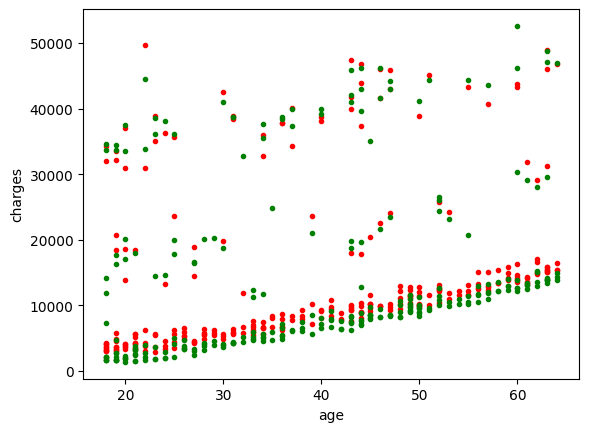

In [16]:
import matplotlib.pyplot as plt

#Charges = f ( age )
plt.xlabel("age")
plt.ylabel("charges")
plt.plot(X_test["age"], y_predicted, "r.")
plt.plot(X_test["age"], y_test, "g.")
plt.show()

# 3. Export du modèle

In [17]:
import pickle

class ExportData() :
    def __init__(self, param_model, param_X_train, param_X_test, param_y_train, param_y_test) : 
        self.export_object = param_model 
        self.X_train = param_X_train
        self.X_test = param_X_test
        self.y_train = param_y_train
        self.y_test = param_y_test


exportData = ExportData(best_model, X_train, X_test, y_train, y_test)

with open('serialized_model.pkl', 'wb') as writing_file:
    pickle.dump(exportData,writing_file)

# 4. Vérifications & valeurs abérantes

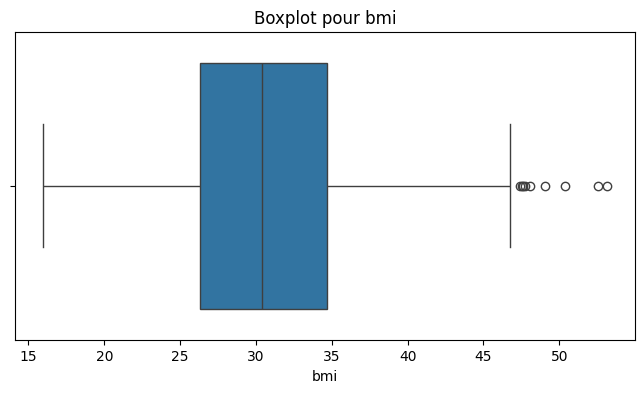

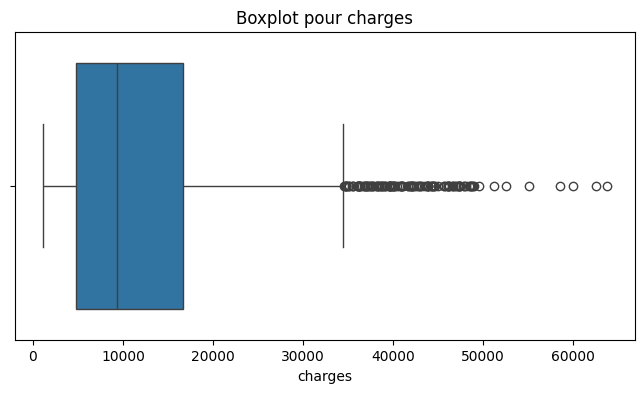

In [18]:
columns_to_check = ['bmi', 'charges']

for col in columns_to_check:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=dataframe[col])
    plt.title(f"Boxplot pour {col}")
    plt.show()

In [19]:
# Fonction pour repérer les valeurs aberrantes basées sur l'IQR
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Repérer les valeurs aberrantes dans `bmi` et `charges`
outliers_bmi = detect_outliers_iqr(dataframe, 'bmi')
outliers_charges = detect_outliers_iqr(dataframe, 'charges')

print("Valeurs aberrantes dans bmi :")
print(outliers_bmi)

print("\nValeurs aberrantes dans charges :")
print(outliers_charges)


Valeurs aberrantes dans bmi :
      age     sex    bmi  children smoker     region      charges bmi_category
116    58    male  49.06         0     no  southeast  11381.32540   obesite_g3
286    46  female  48.07         2     no  northeast   9432.92530   obesite_g3
401    47    male  47.52         1     no  southeast   8083.91980   obesite_g3
543    54  female  47.41         0    yes  southeast  63770.42801   obesite_g3
847    23    male  50.38         1     no  southeast   2438.05520   obesite_g3
860    37  female  47.60         2    yes  southwest  46113.51100   obesite_g3
1047   22    male  52.58         1    yes  southeast  44501.39820   obesite_g3
1088   52    male  47.74         1     no  southeast   9748.91060   obesite_g3
1317   18    male  53.13         0     no  southeast   1163.46270   obesite_g3

Valeurs aberrantes dans charges :
      age     sex     bmi  children smoker     region      charges  \
14     27    male  42.130         0    yes  southeast  39611.75770   
19   

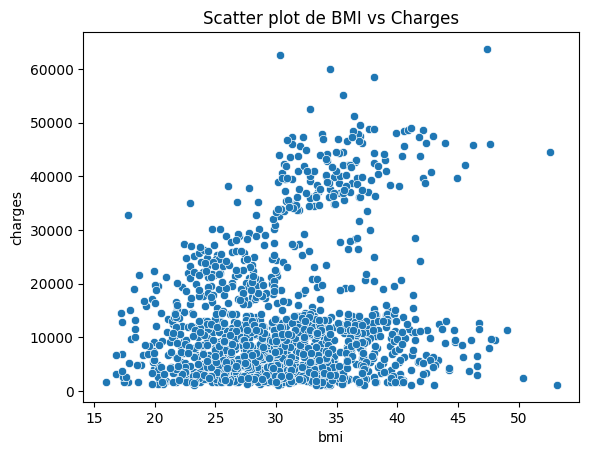

In [20]:
sns.scatterplot(data=dataframe, x='bmi', y='charges')
plt.title("Scatter plot de BMI vs Charges")
plt.show()


In [21]:
dataframe_cleaned = dataframe [dataframe['charges']<=60000]